In [1]:
import pandas as pd

In [2]:
bin_seq_df = pd.read_csv('RandomBinarySeriesWithLLMs.csv')
bin_seq_df.columns

Index(['sequence', 'gpt_4o-program', 'gpt_4o-program-print',
       'gpt_4o-program-correctness', 'gpt_4o-formula', 'gpt_4o-formula-eval',
       'gpt_4o-formula-correctness', 'gpt_4o-formula-ordinal',
       'gpt_4o-formula-copy_seq', 'claude_3.5-program',
       'claude_3.5-program-print', 'Unnamed: 11',
       'claude_3.5-program-correctness', 'claude_3.5-formula',
       'claude_3.5-formula-eval', 'claude_3.5-formula-ordinal',
       'claude_3.5-formula-correctness', 'claude_3.5-formula-copy_seq',
       'gpt_4o_mini-program', 'gpt_4o_mini-formula',
       'gpt_4o_mini-program-print', 'gpt_4o_mini-program-correctness',
       'gpt_4o_mini-formula-correctness', 'gpt_4o_mini-formula-ordinal',
       'gpt_4o_mini-formula-copy_seq', 'cursor_small-program',
       'cursor_small-program-correctness', 'cursor_small-program-print',
       'cursor_small-formula', 'cursor_small-formula-correctness',
       'cursor_small-formula-ordinal', 'cursor_small-formula-copy_seq',
       'gemini-progra

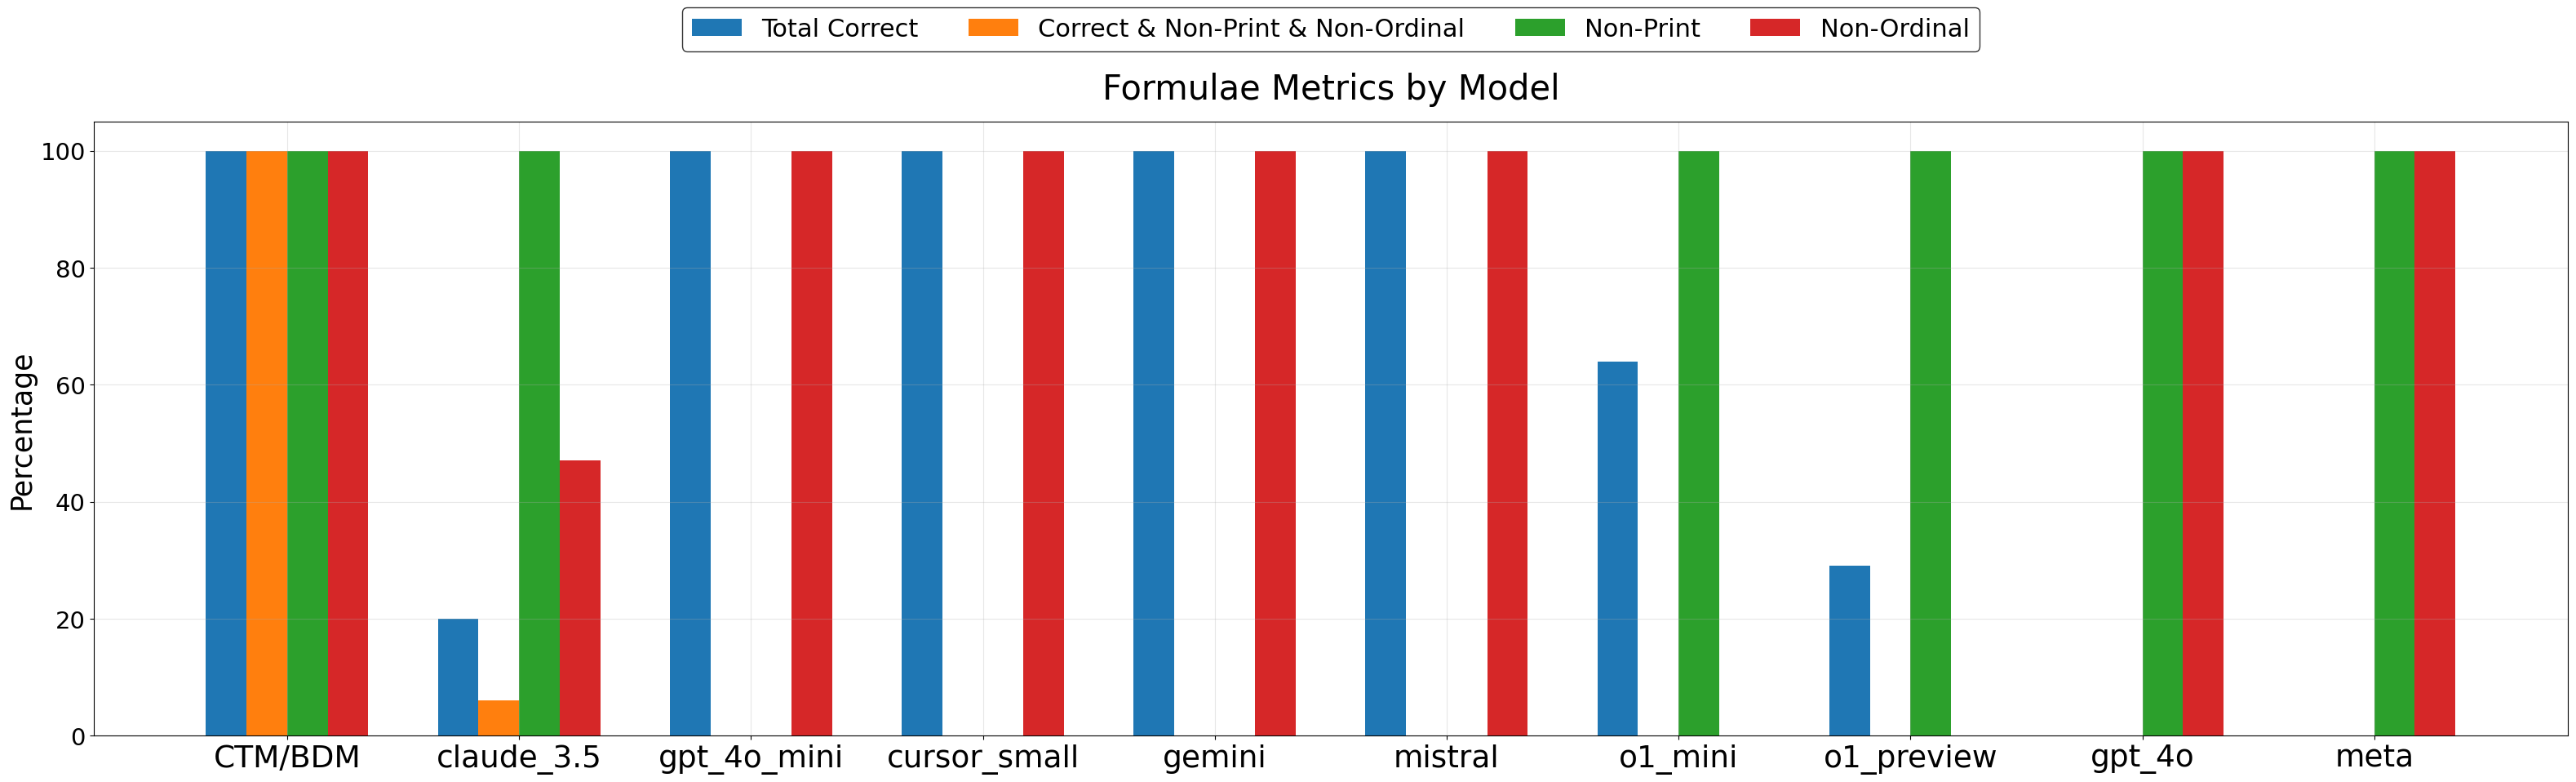

In [176]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique model names
models = ['gpt_4o', 'claude_3.5', 'gpt_4o_mini', 'cursor_small', 'gemini', 'meta', 'o1_mini', 'o1_preview', 'mistral', 'CTM/BDM']

# Initialize data storage for formulas
non_ordinal_data = []
non_copy_seq_data = []
total_correct_data = []
correct_non_both_data = [] # New array for correct & non-print & non-ordinal
prints_data = []
ordinals_data = []
correct_print_data = []
correct_ordinals_data = []

# Collect data for each model
for model in models[:-1]:  # Exclude CTM/BDM from regular processing
    corr_col = f'{model}-formula-correctness'
    ord_col = f'{model}-formula-ordinal'
    copy_col = f'{model}-formula-copy_seq'
    
    if all(col in bin_seq_df.columns for col in [corr_col, ord_col, copy_col]):
        # Calculate percentages
        non_ordinal = (~bin_seq_df[ord_col]).mean() * 100
        non_copy_seq = (~bin_seq_df[copy_col]).mean() * 100
        total_correct = bin_seq_df[corr_col].mean() * 100
        # New metric for correct & non-print & non-ordinal
        correct_non_both = (bin_seq_df[corr_col] & ~bin_seq_df[ord_col] & ~bin_seq_df[copy_col]).mean() * 100
        
        # New metrics
        prints = (bin_seq_df[copy_col]).mean() * 100
        ordinals = (bin_seq_df[ord_col]).mean() * 100
        correct_print = (bin_seq_df[corr_col] & bin_seq_df[copy_col]).mean() * 100
        correct_ordinal = (bin_seq_df[corr_col] & bin_seq_df[ord_col]).mean() * 100
         
        non_ordinal_data.append(non_ordinal)
        non_copy_seq_data.append(non_copy_seq)
        total_correct_data.append(total_correct)
        correct_non_both_data.append(correct_non_both)
        prints_data.append(prints)
        ordinals_data.append(ordinals)
        correct_print_data.append(correct_print)
        correct_ordinals_data.append(correct_ordinal)
    else:
        print(f'{model} - missing columns')
        non_ordinal_data.append(0)
        non_copy_seq_data.append(0)
        total_correct_data.append(0)
        correct_non_both_data.append(0)
        prints_data.append(0)
        ordinals_data.append(0)
        correct_print_data.append(0)
        correct_ordinals_data.append(0)

# Add CTM/BDM data with 100% for all metrics
non_ordinal_data.append(100)
non_copy_seq_data.append(100)
total_correct_data.append(100)
correct_non_both_data.append(100)
prints_data.append(0)
ordinals_data.append(0)
correct_print_data.append(0)
correct_ordinals_data.append(0)

# Create DataFrame with all metrics
df_data = {
    'model': models,
    'non_ordinal': non_ordinal_data,
    'non_copy_seq': non_copy_seq_data,
    'total_correct': total_correct_data,
    'correct_non_both': correct_non_both_data,
    'prints': prints_data,
    'ordinals': ordinals_data,
    'correct_print': correct_print_data,
    'correct_ordinals': correct_ordinals_data
}
ranking_df = pd.DataFrame(df_data)

# Calculate ranking using provided formula
ranking_df['ranking'] = (
    (ranking_df['non_copy_seq'] * ranking_df['non_ordinal'] * ranking_df['total_correct']) / 10000
    +(ranking_df['total_correct'] * (ranking_df['correct_ordinals']) * (ranking_df['correct_print']))/10000
    + (ranking_df['correct_print'] / 100) + (ranking_df['correct_ordinals'] / 1000)
    - (100-ranking_df['ordinals'])*(ranking_df['correct_ordinals']/100)
    - (100-ranking_df['prints'])*(ranking_df['correct_print']/100)
)

# Sort by ranking in descending order
ranking_df = ranking_df.sort_values('ranking', ascending=False)

# Create figure with more height to accommodate title and legend
plt.figure(figsize=(32, 10))

# Increase font sizes
plt.rcParams.update({'font.size': 21})

# Use the sorted data
models = ranking_df['model'].tolist()
non_ordinal_data = ranking_df['non_ordinal'].tolist()
non_copy_seq_data = ranking_df['non_copy_seq'].tolist()
total_correct_data = ranking_df['total_correct'].tolist()
correct_non_both_data = ranking_df['correct_non_both'].tolist()

# Set the positions of the bars
x = np.arange(len(models)) * 2
width = 0.35

# Create subplot with adjusted height ratios
plt.subplots_adjust(top=0.85)  # Make room for title and legend

# Add title
plt.title('Formulae Metrics by Model', fontsize=30, pad=20)

# Plot all sets of data as grouped bars
plt.bar(x - 1.5*width, total_correct_data, width, label='Total Correct', color='#1f77b4')
plt.bar(x - 0.5*width, correct_non_both_data, width, label='Correct & Non-Print & Non-Ordinal', color='#ff7f0e')
plt.bar(x + 0.5*width, non_copy_seq_data, width, label='Non-Print', color='#2ca02c')
plt.bar(x + 1.5*width, non_ordinal_data, width, label='Non-Ordinal', color='#d62728')

# Customize the plot
plt.ylabel('Percentage', fontsize=25)
plt.xticks(x, models, rotation=0, fontsize=27)
plt.grid(True, alpha=0.3)

# Place legend above the plot with clear spacing
plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', ncol=4, fontsize=22, frameon=True, 
          facecolor='white', edgecolor='black')

plt.tight_layout()
plt.show()

In [15]:
ranking_df_copy = ranking_df.copy()
ranking_df_copy


,model,non_ordinal,non_copy_seq,total_correct,correct_non_both,prints,ordinals,correct_print,correct_ordinals,ranking
0,gpt_4o,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,gpt_4o_mini,100.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0,1
3,cursor_small,100.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0,2
4,gemini,100.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0,3
5,meta,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,4
6,o1_mini,0.0,100.0,64.0,0.0,0.0,100.0,0.0,64.0,5
7,o1_preview,0.0,100.0,29.0,0.0,0.0,100.0,0.0,29.0,6
8,mistral,100.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0,7
1,claude_3.5,47.0,100.0,20.0,6.0,0.0,53.0,0.0,14.0,8
9,CTM/BDM,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,9


In [17]:
# *********************************************************
# *********************************************************
ranking_df_copy['theoretical_ranking'] = (
    (ranking_df_copy['non_copy_seq'] * ranking_df_copy['non_ordinal'] * ranking_df_copy['correct_non_both']) / 10000
    - (ranking_df_copy['total_correct'] * (100 - ranking_df_copy['non_ordinal']) * (100 - ranking_df_copy['non_copy_seq']) / 10000)
    + (ranking_df_copy['total_correct'] / 1000)
)
# Sort by theoretical rank
ranking_df_copy = ranking_df_copy.sort_values('theoretical_ranking', ascending=False)
ranking_df_copy[['model', 'non_ordinal', 'non_copy_seq', 'total_correct', 'correct_non_both', 'theoretical_ranking']]



,model,non_ordinal,non_copy_seq,total_correct,correct_non_both,theoretical_ranking
9,CTM/BDM,100.0,100.0,100.0,100.0,100.100
1,claude_3.5,47.0,100.0,20.0,6.0,2.840
2,gpt_4o_mini,100.0,0.0,100.0,0.0,0.100
3,cursor_small,100.0,0.0,100.0,0.0,0.100
4,gemini,100.0,0.0,100.0,0.0,0.100
8,mistral,100.0,0.0,100.0,0.0,0.100
6,o1_mini,0.0,100.0,64.0,0.0,0.064
7,o1_preview,0.0,100.0,29.0,0.0,0.029
0,gpt_4o,100.0,100.0,0.0,0.0,0.000
5,meta,100.0,100.0,0.0,0.0,0.000
